0. Import library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from sklearn.cluster import KMeans

1. Load data 

In [2]:
breed_data = pd.read_csv('./dog_data/labels.csv')
image_folder = "./dog_data/train/"

In [3]:
breed_data.tail()

,id,breed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


In [4]:
breed_data.breed.value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

2. Same Amount of Data 

In [5]:
# 품종별 최소 데이터 갯수 찾기
# value_counts()를 통해 가장적은 품종 갯수(=66) 확인했음
min_samples_per_breed = 66 

# 각 품종에서 최소 데이터 갯수만큼 랜덤하게 샘플 선택
selected_samples = []
for breed in breed_data['breed'].unique():
    breed_samples = breed_data[breed_data['breed'] == breed].sample(min_samples_per_breed, random_state=42)
    selected_samples.append(breed_samples)

# 선택된 샘플을 하나의 데이터프레임으로 합치기
selected_data = pd.concat(selected_samples, ignore_index=True)

3. Clustering

In [7]:
# 이미지 특성 추출을 위한 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# 이미지 경로를 특성 벡터로 변환하는 함수
def path_to_features(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.flatten()

# 데이터 크기 조절
# sample_size = 1000
sample_size = len(selected_data)  # 전체 데이터 사용
breed_data_sample = selected_data.sample(n=sample_size, random_state=42)

# 특성 추출
image_paths_sample = [f"{image_folder}{img}.jpg" for img in breed_data_sample['id']]
features_sample = np.array([path_to_features(img_path) for img_path in image_paths_sample])

# K-means 클러스터링
num_clusters = 20  # 대표종으로 선택할 클러스터 수
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
breed_data_sample['cluster'] = kmeans.fit_predict(features_sample)


1/1 [==============================] - 0s 75ms/step


c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


4. Select Representative Breed

In [7]:
# 빈도수 기반 대표종 선택
representative_breeds_sample = breed_data_sample.groupby('cluster')['breed'].value_counts().groupby('cluster').idxmax().apply(lambda x: x[1])

# 대표종 출력
print("Representative 20 Breeds")
print(representative_breeds_sample)

Representative 20 Breeds
cluster
0                  airedale
1                     dhole
2              bull_mastiff
3                   redbone
4             silky_terrier
5     flat-coated_retriever
6                      chow
7         shetland_sheepdog
8               toy_terrier
9               entlebucher
10                   borzoi
11                 malamute
12      irish_water_spaniel
13         sealyham_terrier
14         english_foxhound
15         brittany_spaniel
16                 komondor
17           sussex_spaniel
18       kerry_blue_terrier
19         japanese_spaniel
Name: count, dtype: object


5. Visualization

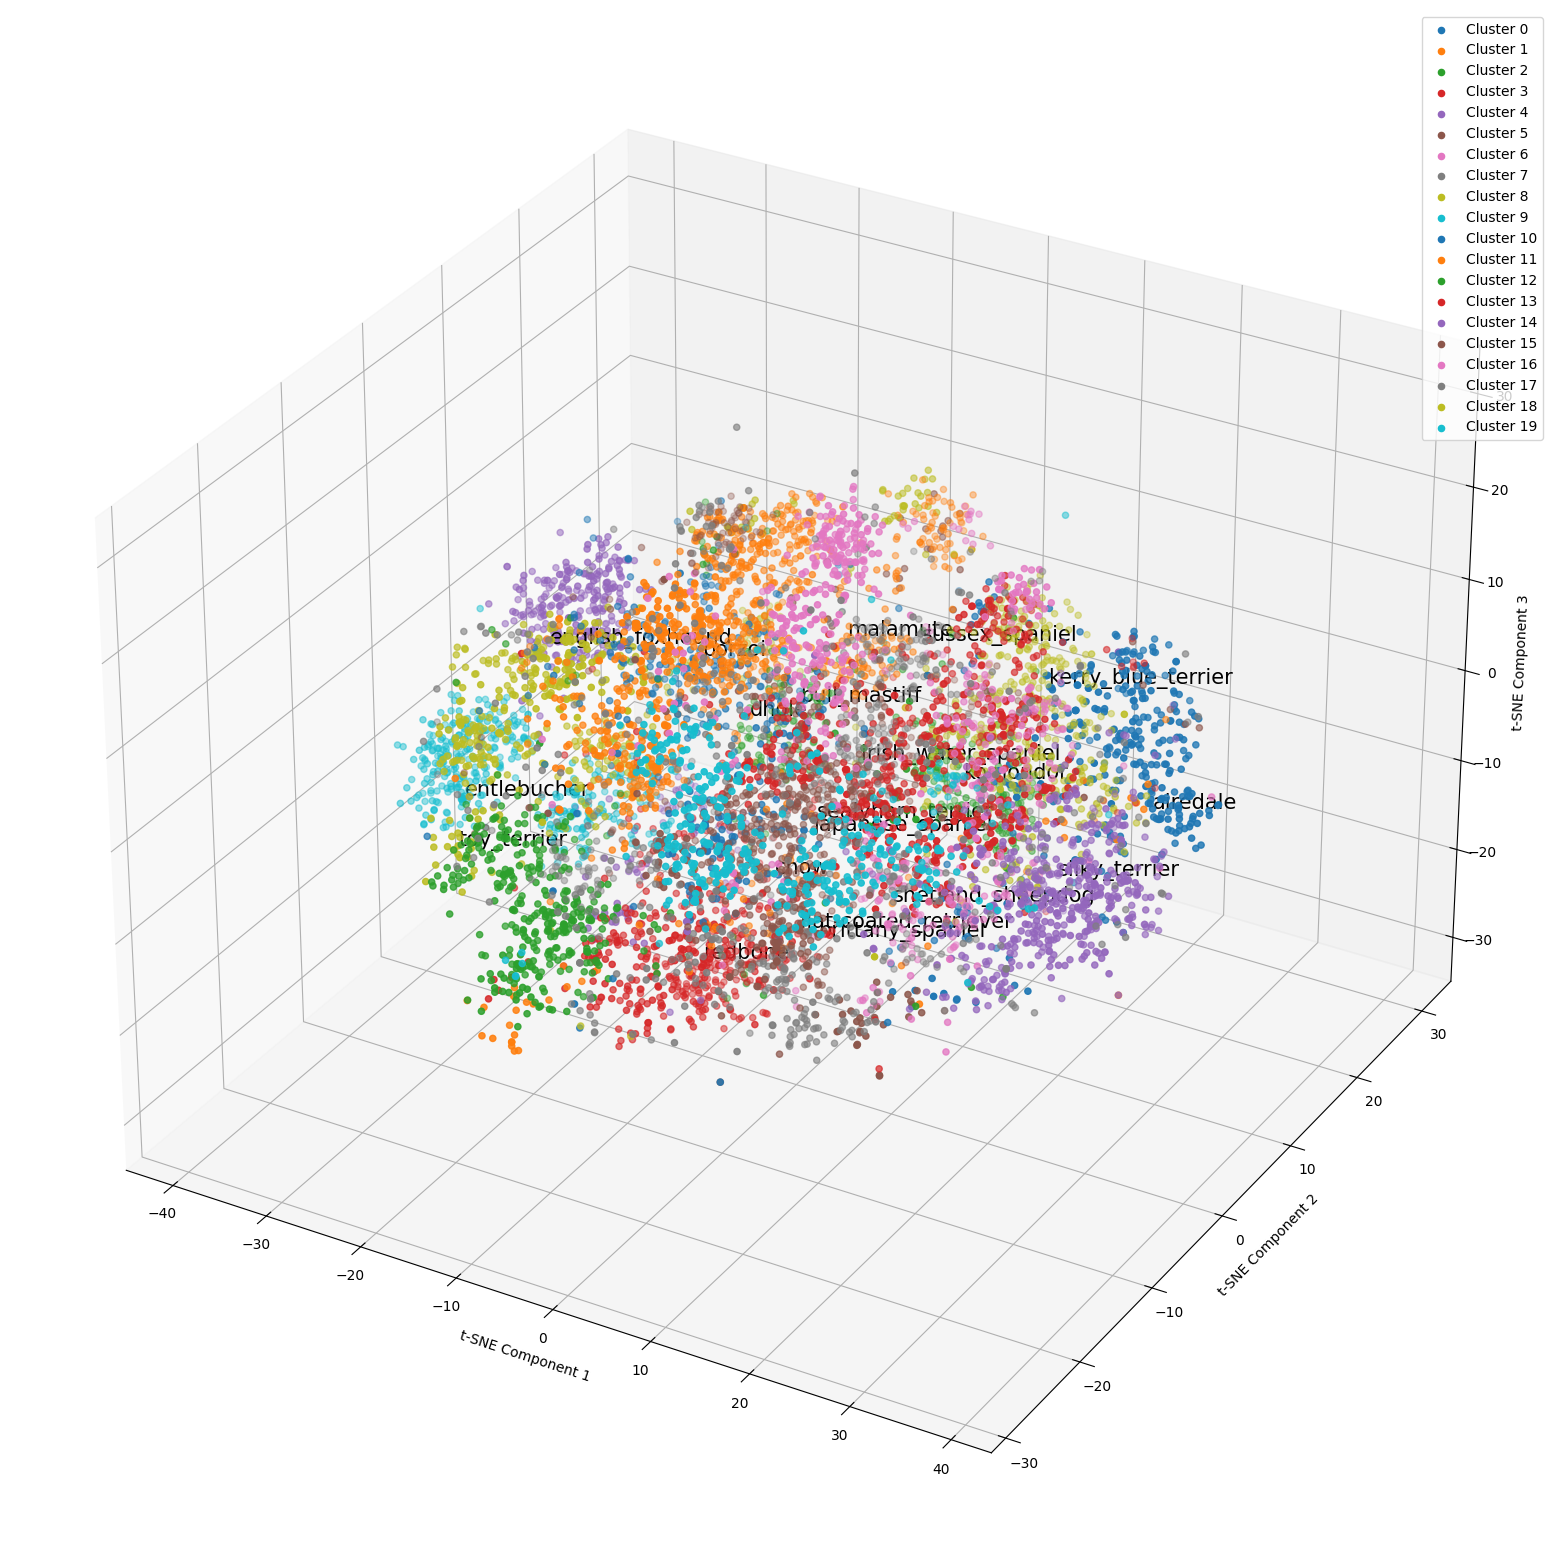

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 모델 생성
tsne = TSNE(n_components=3, random_state=42)

# ResNet50을 통해 얻은 특성 벡터에 t-SNE 적용
features_tsne = tsne.fit_transform(features_sample)

# 3D 시각화
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# 각 클러스터에 대해 특성 벡터를 표시
for cluster in range(num_clusters):
    cluster_indices = np.where(breed_data_sample['cluster'] == cluster)[0]
    ax.scatter(features_tsne[cluster_indices, 0], features_tsne[cluster_indices, 1], features_tsne[cluster_indices, 2], label=f'Cluster {cluster}')

# 대표종 표시
for cluster, breed in representative_breeds_sample.items():
    if cluster in range(num_clusters):
        cluster_index = np.where(breed_data_sample['cluster'] == cluster)[0][0]
        ax.text(features_tsne[cluster_index, 0], features_tsne[cluster_index, 1], features_tsne[cluster_index, 2], breed, fontsize=15)

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend()
plt.show()


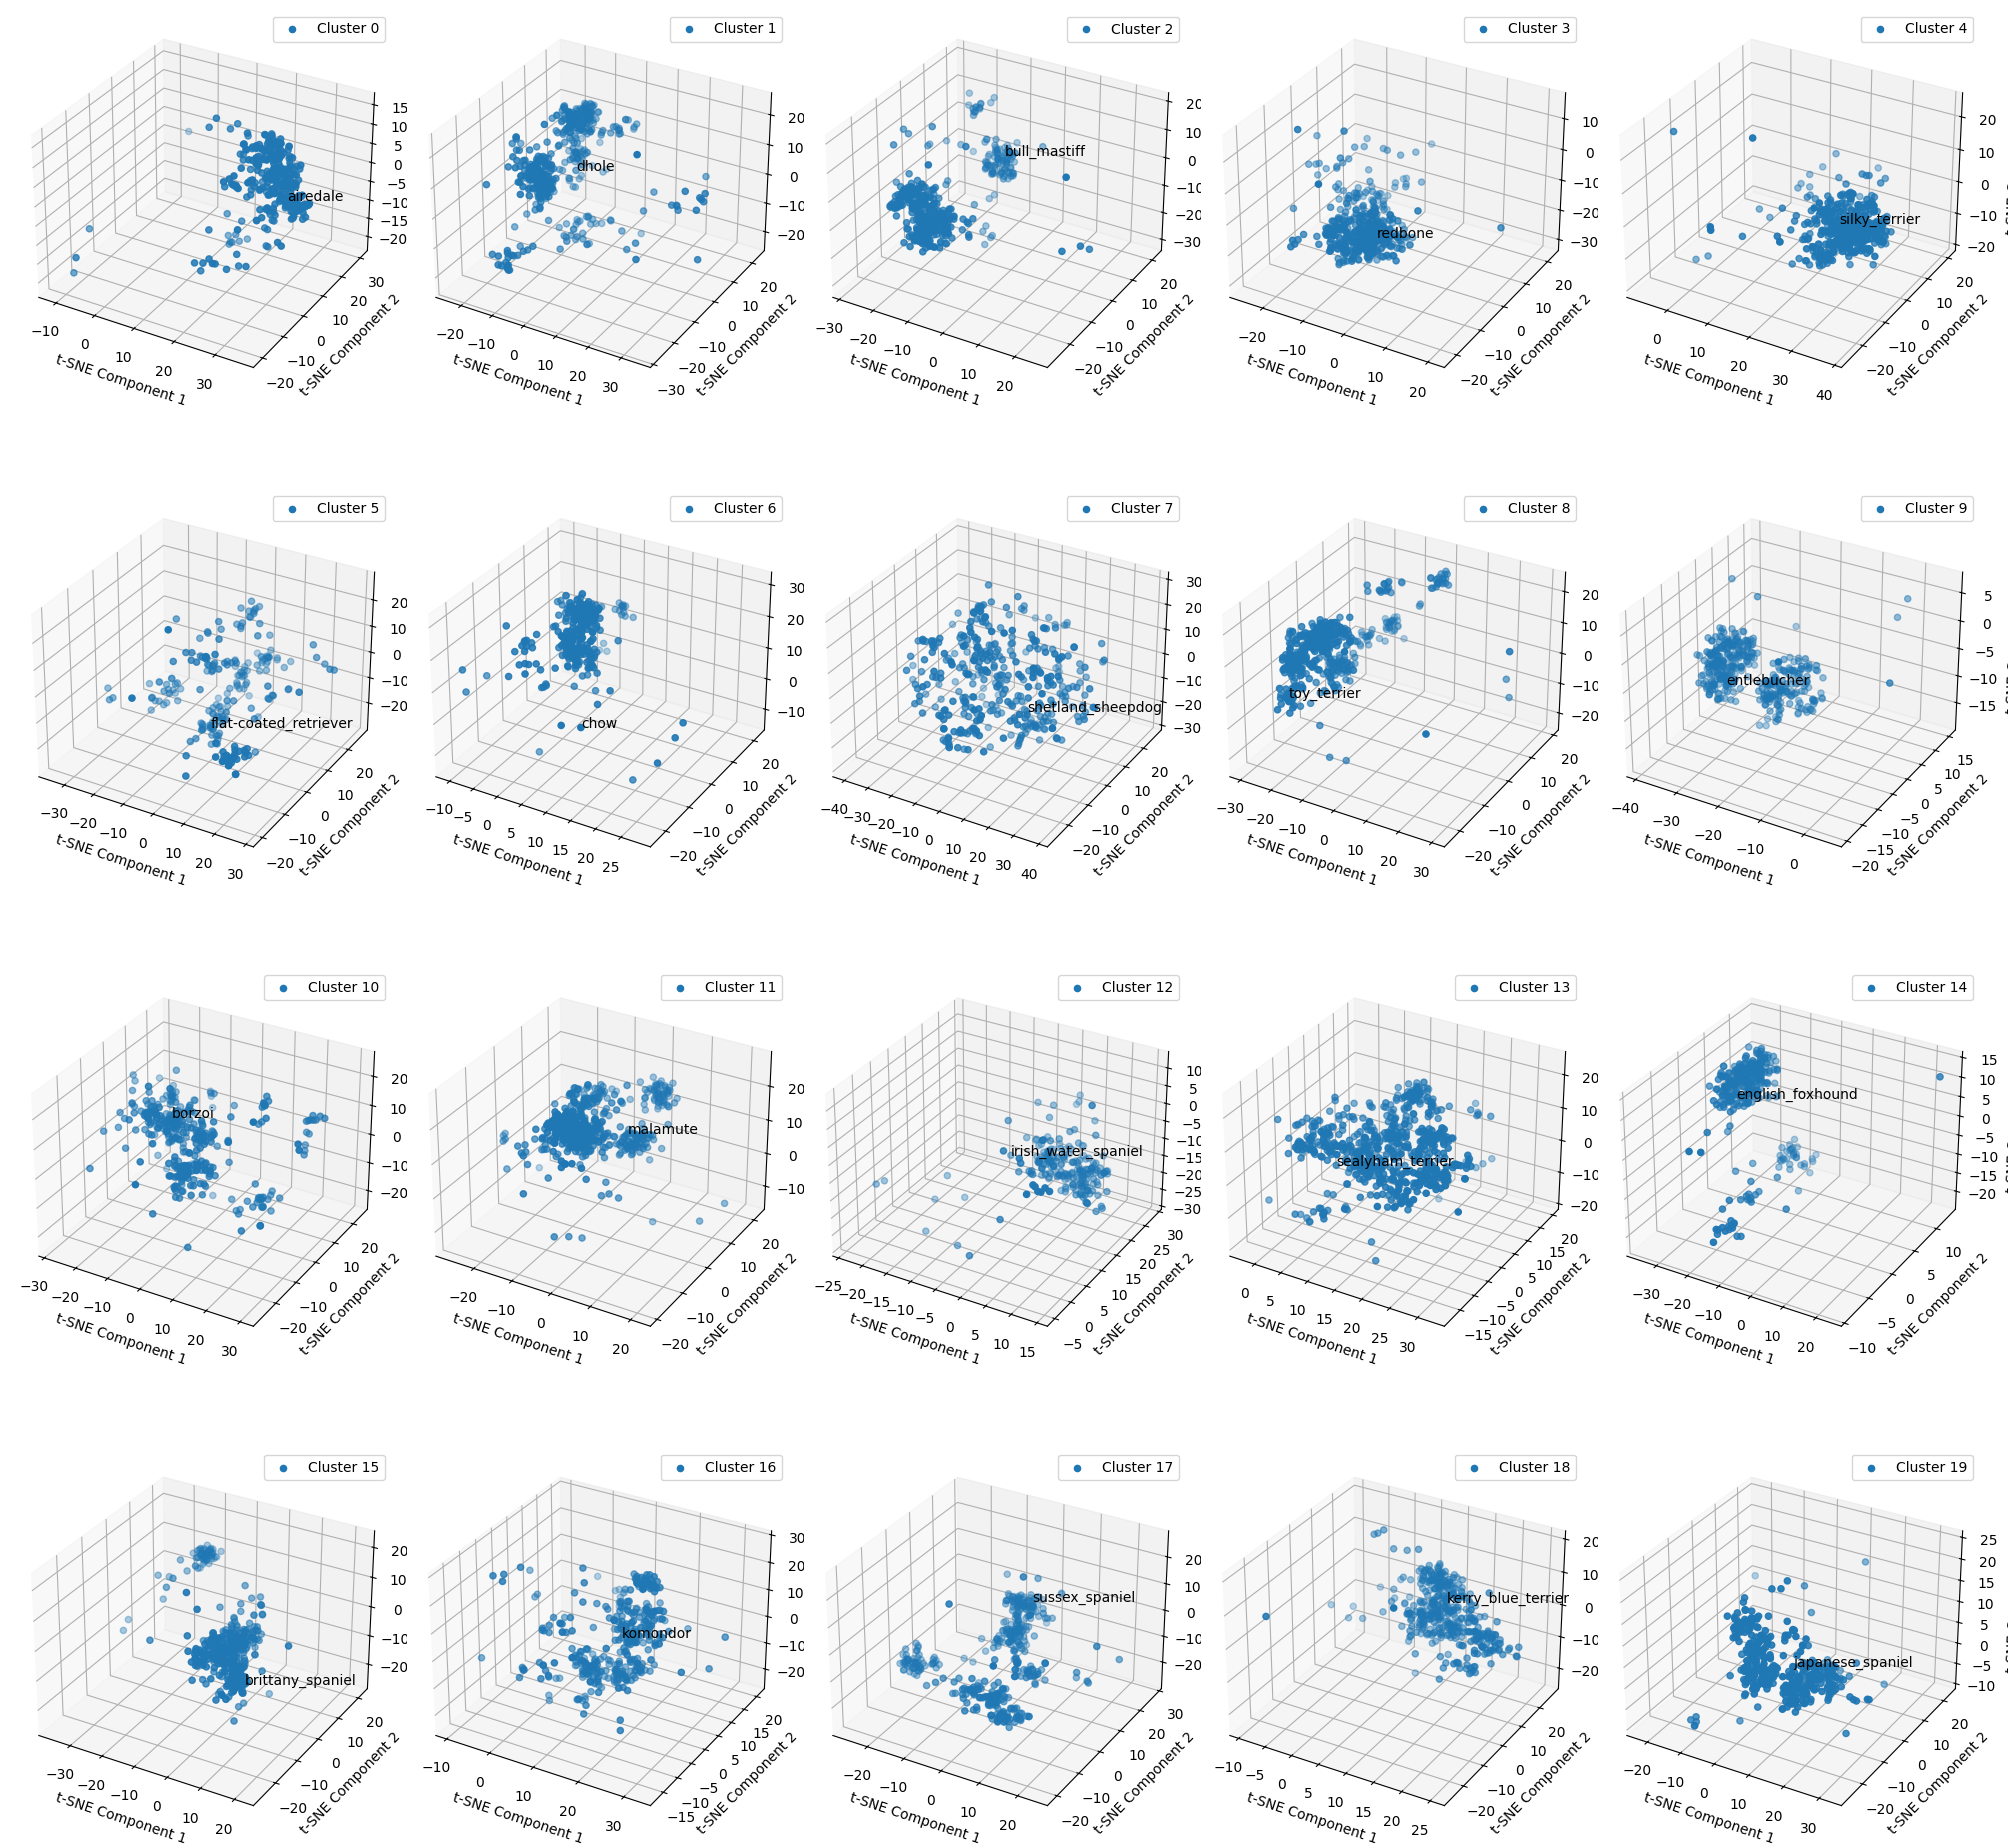

In [11]:
# 3D 시각화
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20), subplot_kw={'projection': '3d'})

# 각 클러스터에 대해 특성 벡터를 표시
for cluster, ax in zip(range(num_clusters), axes.flatten()):
    cluster_indices = np.where(breed_data_sample['cluster'] == cluster)[0]
    ax.scatter(features_tsne[cluster_indices, 0], features_tsne[cluster_indices, 1], features_tsne[cluster_indices, 2], label=f'Cluster {cluster}')

    # 대표종 표시
    if cluster in representative_breeds_sample.index:
        cluster_index = np.where(breed_data_sample['cluster'] == cluster)[0][0]
        ax.text(features_tsne[cluster_index, 0], features_tsne[cluster_index, 1], features_tsne[cluster_index, 2], representative_breeds_sample[cluster], fontsize=10)

    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    ax.legend()

plt.tight_layout()
plt.show()
